In [16]:
import pandas as pd
import os
import csv
import re
import sys
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [17]:
# Function to extract the numeric part of the filename (after the last underscore and before the file extension)
def extract_numeric_part(path):
    # This regex extracts the number after the last underscore and before the file extension (.flac)
    match = re.search(r'_(\d+)\.flac$', path)
    if match:
        return match.group(1)  # Return only the numeric part
    return None  # Return None if the pattern doesn't match

def extract_numeric_part_npy(path):
    # This regex extracts the number after the last underscore and before the file extension (.flac)
    match = re.search(r'_E_(\d+)_None\.npy$', path)
    if match:
        return match.group(1)  # Return only the numeric part
    return None  # Return None if the pattern doesn't match


def pred_and_labels_clean(file1_csv, file2_csv, feature):
    '''
    file1: probabilities list .csv
    file2: eval dataset .csv
    '''
    
    prediction_list = []
    label_list = []
    pred_class1_list = []
    
    # Step 1: Read file2 into a dictionary for quick look-up based on the numeric part of the file path
    file2_dict = {}
    with open(file2_csv, mode='r') as file2:
        reader = csv.DictReader(file2)
        for row in reader:
            numeric_file2 = extract_numeric_part(row['path'])
            if numeric_file2:
                file2_dict[numeric_file2] = row['label']

    # Step 2: Traverse file1 and check against file2 dictionary, using tqdm for progress tracking
    with open(file1_csv, mode='r') as file1:
        reader = csv.DictReader(file1)
        total_rows = sum(1 for _ in open(file1_csv)) - 1  # Calculate total rows for the progress bar (excluding header)
    
        file1.seek(0)  # Reset the reader position back to the start of the file after counting
        if feature == 'audio':
            for row in reader:
                # Extract the numeric part from file1's path
                file1_path = row['Filename']
                numeric_file1 = extract_numeric_part(file1_path)
        
                # Step 3: Check if the numeric part exists in the file2 dictionary
                if numeric_file1 and numeric_file1 in file2_dict:
                    pred_class_0 = float(row['Pred.class 0'])
                    pred_class_1 = float(row['Pred.class 1'])
            
                    # Step 4: Append prediction based on comparison
                    prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                    # Step 5: Append the corresponding label from file2
                    label_list.append(int(file2_dict[numeric_file1]))
                
                    # Step 6:  Append Pred.class 1 value to the new list
                    pred_class1_list.append(pred_class_1)
        elif feature == 'spec':
            for row in reader:
                # Extract the numeric part from file1's path
                file1_path = row['Filename']
                numeric_file1 = extract_numeric_part_npy(file1_path)
        
                # Step 3: Check if the numeric part exists in the file2 dictionary
                if numeric_file1 and numeric_file1 in file2_dict:
                    pred_class_0 = float(row['Pred.class 0'])
                    pred_class_1 = float(row['Pred.class 1'])
            
                    # Step 4: Append prediction based on comparison
                    prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                    # Step 5: Append the corresponding label from file2
                    label_list.append(int(file2_dict[numeric_file1]))
                
                    # Step 6:  Append Pred.class 1 value to the new list
                    pred_class1_list.append(pred_class_1)
    
    return prediction_list, label_list, pred_class1_list




def pred_and_labels_attack(file1_csv, file2_csv):
    
    def extract_numeric_part(path):
        # This regex captures the numeric part following 'LA_E_' and stops at the next underscore or period
        match = re.search(r'LA_E_(\d+)', path)
        if match:
            return match.group(1)  # Return only the numeric part
        return None  # Return None if the pattern doesn't match
    
    prediction_list = []
    label_list = []
    pred_class1_list = []
    
    # Step 1: Read file2 into a dictionary for quick look-up based on the numeric part of the file path
    file2_dict = {}
    with open(file2_csv, mode='r') as file2:
        reader = csv.DictReader(file2)
        for row in reader:
            numeric_file2 = extract_numeric_part(row['path'])
            if numeric_file2:
                file2_dict[numeric_file2] = row['label']

    # Step 2: Traverse file1 and check against file2 dictionary, using tqdm for progress tracking
    with open(file1_csv, mode='r') as file1:
        reader = csv.DictReader(file1)
        total_rows = sum(1 for _ in open(file1_csv)) - 1  # Calculate total rows for the progress bar (excluding header)
    
        file1.seek(0)  # Reset the reader position back to the start of the file after counting
        for row in reader:
            # Extract the numeric part from file1's path
            file1_path = row['Filename']
            numeric_file1 = extract_numeric_part(file1_path)
        
            # Step 3: Check if the numeric part exists in the file2 dictionary
            if numeric_file1 and numeric_file1 in file2_dict:
                pred_class_0 = float(row['Pred.class 0'])
                pred_class_1 = float(row['Pred.class 1'])
            
                # Step 4: Append prediction based on comparison
                prediction_list.append(0 if pred_class_0 > pred_class_1 else 1)
            
                # Step 5: Append the corresponding label from file2
                label_list.append(int(file2_dict[numeric_file1]))
                
                # Step 6:  Append Pred.class 1 value to the new list
                pred_class1_list.append(pred_class_1)

    
    return prediction_list, label_list, pred_class1_list

In [18]:
def compute_eer(y_true, y_scores):
    # Step 1: Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Step 2: Compute FNR (1 - TPR)
    fnr = 1 - tpr

    # Step 3: Find the threshold where FPR is closest to FNR
    eer_threshold = thresholds[np.nanargmin(np.abs(fpr - fnr))]

    # Step 4: EER is the value of FPR (or FNR) at that threshold
    eer = fpr[np.nanargmin(np.abs(fpr - fnr))]

    return eer, eer_threshold


def ROC(attack, attack_model, epsilon, eval_model, model_version, dataset, type_of_spec, feature, q_1=None, q_2=None, q_3=None, eps1=None, eps2=None, eps3=None, trip=0):
   
    epsilon_str = str(epsilon).replace('.', 'dot')
    eps1_str = str(eps1).replace('.', 'dot')
    eps2_str = str(eps2).replace('.', 'dot')
    eps3_str = str(eps3).replace('.', 'dot')
    
    script_dir = os.getcwd()
    probs_csv_c = f'probs_{eval_model}_{model_version}_clean_{dataset}_{type_of_spec}_{feature}.csv'
    
    if attack != 'Ens1D' and attack != 'Ens2D':
        probs_csv_p = f'probs_{eval_model}_{model_version}_{attack}_{attack_model}_{dataset}_{epsilon_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ens1D' and trip==0:
        probs_csv_p = f'probs_{eval_model}_{model_version}_Ens1D_{attack_model}_{q_1}_{q_2}_{eps1_str}_{eps2_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ens1D' and trip==1:
        probs_csv_p = f'probs_{eval_model}_{model_version}_Ens1D_{attack_model}_{q_1}_{q_2}_{q_3}_{eps1_str}_{eps2_str}_{eps3_str}_{type_of_spec}_{feature}.csv'
    elif attack == 'Ens2D':
        sys.exit('TODO 2D ens')  
        
    #print(probs_csv_p)
    if dataset == '3s' and trip == 0:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19_3s.csv' )
    elif dataset == 'whole' and trip == 0:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19.csv' )
    elif dataset == 'whole' and trip == 1:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19_reduced.csv' )
    
    # get GT labels
    pred_list_c, labels_list_c, pred_1_c = pred_and_labels_clean(file1_csv=probs_csv_c, file2_csv=eval_csv, feature=feature)
    labels_c = np.array(labels_list_c)
    pred_1_c = np.array(pred_1_c)
    
    pred_list_p, labels_list_p, pred_1_p = pred_and_labels_attack(file1_csv=probs_csv_p, file2_csv=eval_csv)
    labels_p = np.array(labels_list_p)
    pred_1_p = np.array(pred_1_p)
    
    if len(pred_list_c) != len(pred_list_p):
        sys.exit(f'length of clean is {len(pred_list_c)}, length of pert is {len(pred_list_p)}')
    
    # CLEAN - compute ROC, AUC, EER
    fpr_c, tpr_c, _ = roc_curve(labels_c, pred_1_c)
    roc_auc_c = auc(fpr_c, tpr_c)
    eer_c, _ = compute_eer(labels_c, pred_1_c)
    
    # PERTURBED - compute ROC, AUC, EER
    fpr_p, tpr_p, _ = roc_curve(labels_p, pred_1_p)
    roc_auc_p = auc(fpr_p, tpr_p)
    eer_p, _ = compute_eer(labels_p, pred_1_p)
    
    # plt.figure()
    # plt.plot(fpr_c, tpr_c, color='darkorange', lw=1.5, label='Clean (AUC={:.2f})'.format(roc_auc_c))
    # plt.plot(fpr_p, tpr_p, color='red', lw=1.5, label='Perturbed (AUC={:.2f})'.format(roc_auc_p))
    # plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
    # # Set axis limits and labels
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # if attack != 'Ens1D' or attack != 'Ens2D':
    #     plt.title(f'ROC - {attack} on {attack_model}, eps={epsilon}, eval model: {eval_model}')
    # elif attack == 'Ens1D':
    #     plt.title(f'ROC - {attack} on {attack_model}, {eps1}, {eps2}, {q_1}, {q_2}, eval model: {eval_model}')
    # plt.legend(loc='lower right')
    # plt.show()
    
    if attack != 'Ens1D' and attack != 'Ens2D':
        print(f'{feature} - {attack} on {attack_model} with eps={epsilon} evaluated on {eval_model}\nAUC clean: {roc_auc_c:.3f}, EER clean: {eer_c*100:.3f}\n--> AUC perturbed: {roc_auc_p:.3f}, EER perturbed: {eer_p*100:.3f} <-- \n------------------------')
    elif attack == 'Ens1D' and trip==0:
        print(f'{feature} - {attack} on {attack_model} with q1={q_1}, q2={q_2}, eps1={eps1}, eps2={eps2} evaluated on {eval_model}\nAUC clean: {roc_auc_c:.3f}, EER clean: {eer_c*100:.3f}\n--> AUC perturbed: {roc_auc_p:.3f}, EER perturbed: {eer_p*100:.3f} <-- \n------------------------')
    elif attack == 'Ens1D' and trip==1:
        print(f'{feature} - {attack} on {attack_model} with q1={q_1}, q2={q_2}, q3={q_3}, eps1={eps1}, eps2={eps2}, eps3={eps3}  evaluated on {eval_model}\nAUC clean: {roc_auc_c:.3f}, EER clean: {eer_c*100:.3f}\n--> AUC perturbed: {roc_auc_p:.3f}, EER perturbed: {eer_p*100:.3f} <-- \n------------------------')
    elif attack == 'Ens2D':
        sys.exit('TODO 2d ens')
    
    return fpr_c, tpr_c, roc_auc_c, fpr_p, tpr_p, roc_auc_p, eer_c, eer_p
    

In [19]:
def ROC_clean_only(eval_model, model_version, dataset, type_of_spec, feature):
   
    script_dir = os.getcwd()
    probs_csv_c = f'probs_{eval_model}_{model_version}_clean_{dataset}_{type_of_spec}_{feature}.csv'
         
    #print(probs_csv_p)
    if dataset == '3s':
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19_3s.csv' )
    else:
        eval_csv = os.path.join(os.path.dirname(script_dir), 'data', 'df_eval_19.csv' )
    
    # get GT labels
    pred_list_c, labels_list_c, pred_1_c = pred_and_labels_clean(file1_csv=probs_csv_c, file2_csv=eval_csv, feature=feature)
    labels_c = np.array(labels_list_c)
    pred_1_c = np.array(pred_1_c)
    
     
    # CLEAN - compute ROC, AUC, EER
    fpr_c, tpr_c, _ = roc_curve(labels_c, pred_1_c)
    roc_auc_c = auc(fpr_c, tpr_c)
    eer_c, _ = compute_eer(labels_c, pred_1_c)
    
    # plt.figure()
    # plt.plot(fpr_c, tpr_c, color='darkorange', lw=1.5, label='Clean (AUC={:.2f})'.format(roc_auc_c))
    # plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
    # # Set axis limits and labels
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'{eval_model} {model_version} clean')
    # plt.legend(loc='lower right')
    # plt.show()
    print(f'{feature} -- AUC = {roc_auc_c:.3f}, EER = {eer_c*100:.3f}')
    
    return roc_auc_c, eer_c

***
## Verify pipeline using ResNet2

In [20]:
_,_,_, fpr_Res2D_NoAttack, tpr_Res2D_NoAttack, roc_auc_Res2D_NoAttack, eer_Res2D_c, eer_Res2D_NoAttack = ROC(attack='NoAttack', attack_model='ResNet2D', epsilon=None, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

audio - NoAttack on ResNet2D with eps=None evaluated on ResNet2D
AUC clean: 0.954, EER clean: 9.667
--> AUC perturbed: 0.954, EER perturbed: 9.640 <-- 
------------------------


In [21]:
_,_,_, fpr_Res2D_NoAttack, tpr_Res2D_NoAttack, roc_auc_Res2D_NoAttack, eer_Res2D_c, eer_Res2D_NoAttack = ROC(attack='NoAttack', attack_model='ResNet2D', epsilon=None, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='spec', q_1=None, q_2=None)

spec - NoAttack on ResNet2D with eps=None evaluated on ResNet2D
AUC clean: 0.954, EER clean: 9.667
--> AUC perturbed: 0.954, EER perturbed: 9.667 <-- 
------------------------


***
## Normal attacks

In [22]:
# ResNet2D

fpr_Res2D_c, tpr_Res2D_c, roc_auc_Res2D_c, fpr_Res2D_BIM_Res2D, tpr_Res2D_BIM_Res2D, roc_auc_Res2D_BIM_Res2D, eer_Res2D_c, eer_Res2D_BIM_Res2D = ROC(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

fpr_Res2Ds_c, tpr_Res2Ds_c, roc_auc_Res2Ds_c, fpr_Res2Ds_BIM_Res2D, tpr_Res2Ds_BIM_Res2D, roc_auc_Res2Ds_BIM_Res2D, eer_Res2Ds_c, eer_Res2Ds_BIM_Res2D = ROC(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='spec', q_1=None, q_2=None)

_,_,_, fpr_Res2D_BIM_Res1D, tpr_Res2D_BIM_Res1D, roc_auc_Res2D_BIM_Res1D, _, eer_Res2D_BIM_Res1D = ROC(attack='BIM', attack_model='ResNet1D', epsilon=0.025, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_Res2D_BIM_SEN1D, tpr_Res2D_BIM_SEN1D, roc_auc_Res2D_BIM_SEN1D, _, eer_Res2D_BIM_SEN1D = ROC(attack='BIM', attack_model='SENet1D', epsilon=0.006, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

_,_,_, fpr_Res2D_BIM_SEN2D, tpr_Res2D_BIM_SEN2D, roc_auc_Res2D_BIM_SEN2D, _, eer_Res2D_BIM_SEN2D = ROC(attack='BIM', attack_model='SENet2D', epsilon=3.5, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

# _,_,_, fpr_Res2D_BIM_LCNN1D, tpr_Res2D_BIM_LCNN1D, roc_auc_Res2D_BIM_LCNN1D, _, eer_Res2D_BIM_LCNN1D = ROC(attack='BIM', attack_model='LCNN1D', epsilon=0.005, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
# _,_,_, fpr_Res2D_BIM_LCNN2D, tpr_Res2D_BIM_LCNN2D, roc_auc_Res2D_BIM_LCNN2D, _, eer_Res2D_BIM_LCNN2D = ROC(attack='BIM', attack_model='LCNN2D', epsilon=3.0, eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

audio - BIM on ResNet2D with eps=3.0 evaluated on ResNet2D
AUC clean: 0.954, EER clean: 9.667
--> AUC perturbed: 0.004, EER perturbed: 98.151 <-- 
------------------------
spec - BIM on ResNet2D with eps=3.0 evaluated on ResNet2D
AUC clean: 0.954, EER clean: 9.667
--> AUC perturbed: 0.000, EER perturbed: 100.000 <-- 
------------------------
audio - BIM on ResNet1D with eps=0.025 evaluated on ResNet2D
AUC clean: 0.954, EER clean: 9.667
--> AUC perturbed: 0.000, EER perturbed: 99.986 <-- 
------------------------
audio - BIM on SENet1D with eps=0.006 evaluated on ResNet2D
AUC clean: 0.954, EER clean: 9.667
--> AUC perturbed: 0.944, EER perturbed: 12.468 <-- 
------------------------
audio - BIM on SENet2D with eps=3.5 evaluated on ResNet2D
AUC clean: 0.954, EER clean: 9.667
--> AUC perturbed: 0.944, EER perturbed: 10.809 <-- 
------------------------


In [75]:
# ResNet1D

fpr_Res1D_c, tpr_Res1D_c, roc_auc_Res1D_c, fpr_Res1D_BIM_Res1D, tpr_Res1D_BIM_Res1D, roc_auc_Res1D_BIM_Res1D, eer_Res1D_c, eer_Res1D_BIM_Res1D = ROC(attack='BIM', attack_model='ResNet1D', epsilon=0.025, eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

_,_,_, fpr_Res1D_BIM_Res2D, tpr_Res1D_BIM_Res2D, roc_auc_Res1D_BIM_Res2D, _, eer_Res1D_BIM_Res2D = ROC(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_Res1D_BIM_SEN1D, tpr_Res1D_BIM_SEN1D, roc_auc_Res1D_BIM_SEN1D, _, eer_Res1D_BIM_SEN1D = ROC(attack='BIM', attack_model='SENet1D', epsilon=0.006, eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_Res1D_BIM_SEN2D, tpr_Res1D_BIM_SEN2D, roc_auc_Res1D_BIM_SEN2D, _, eer_Res1D_BIM_SEN2D = ROC(attack='BIM', attack_model='SENet2D', epsilon=3.5, eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

# _,_,_, fpr_Res1D_BIM_LCNN1D, tpr_Res1D_BIM_LCNN1D, roc_auc_Res1D_BIM_LCNN1D, _, eer_Res1D_BIM_LCNN1D = ROC(attack='BIM', attack_model='LCNN1D', epsilon=0.005, eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
# _,_,_, fpr_Res1D_BIM_LCNN2D, tpr_Res1D_BIM_LCNN2D, roc_auc_Res1D_BIM_LCNN2D, _, eer_Res1D_BIM_LCNN2D = ROC(attack='BIM', attack_model='LCNN2D', epsilon=3.0, eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

audio - BIM on ResNet1D with eps=0.025 evaluated on ResNet1D
AUC clean: 0.968, EER clean: 7.179
--> AUC perturbed: 0.000, EER perturbed: 100.000 <-- 
------------------------
audio - BIM on ResNet2D with eps=3.0 evaluated on ResNet1D
AUC clean: 0.968, EER clean: 7.179
--> AUC perturbed: 0.622, EER perturbed: 36.139 <-- 
------------------------
audio - BIM on SENet1D with eps=0.006 evaluated on ResNet1D
AUC clean: 0.968, EER clean: 7.179
--> AUC perturbed: 0.949, EER perturbed: 11.706 <-- 
------------------------
audio - BIM on SENet2D with eps=3.5 evaluated on ResNet1D
AUC clean: 0.968, EER clean: 7.179
--> AUC perturbed: 0.946, EER perturbed: 11.040 <-- 
------------------------


In [24]:
# SENet1D

roc_auc_SEN1D_c, eer_SEN1D_c = ROC_clean_only(eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

fpr_SEN1D_c, tpr_SEN1D_c, roc_auc_SEN1D_c, fpr_SEN1D_BIM_SEN1D, tpr_SEN1D_BIM_SEN1D, roc_auc_SEN1D_BIM_SEN1D, eer_SEN1D_c, eer_SEN1D_BIM_SEN1D = ROC(attack='BIM', attack_model='SENet1D', epsilon=0.006, eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_SEN1D_BIM_Res2D, tpr_SEN1D_BIM_Res2D, roc_auc_SEN1D_BIM_Res2D, _, eer_SEN1D_BIM_Res2D = ROC(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_SEN1D_BIM_Res1D, tpr_SEN1D_BIM_Res1D, roc_auc_SEN1D_BIM_Res1D, _, eer_SEN1D_BIM_Res1D = ROC(attack='BIM', attack_model='ResNet1D', epsilon=0.02, eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_SEN1D_BIM_SEN2D, tpr_SEN1D_BIM_SEN2D, roc_auc_SEN1D_BIM_SEN2D, _, eer_SEN1D_BIM_SEN2D = ROC(attack='BIM', attack_model='SENet2D', epsilon=3.5, eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

# _,_,_, fpr_SEN1D_BIM_LCNN1D, tpr_SEN1D_BIM_LCNN1D, roc_auc_SEN1D_BIM_LCNN1D, _, eer_SEN1D_BIM_LCNN1D = ROC(attack='BIM', attack_model='LCNN1D', epsilon=0.005, eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
# _,_,_, fpr_SEN1D_BIM_LCNN2D, tpr_SEN1D_BIM_LCNN2D, roc_auc_SEN1D_BIM_LCNN2D, _, eer_SEN1D_BIM_LCNN2D = ROC(attack='BIM', attack_model='LCNN2D', epsilon=3.0, eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

audio -- AUC = 0.947, EER = 10.374
audio - BIM on SENet1D with eps=0.006 evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.374
--> AUC perturbed: 0.000, EER perturbed: 100.000 <-- 
------------------------
audio - BIM on ResNet2D with eps=3.0 evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.374
--> AUC perturbed: 0.891, EER perturbed: 17.022 <-- 
------------------------
audio - BIM on ResNet1D with eps=0.02 evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.374
--> AUC perturbed: 0.285, EER perturbed: 63.249 <-- 
------------------------
audio - BIM on SENet2D with eps=3.5 evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.374
--> AUC perturbed: 0.925, EER perturbed: 13.188 <-- 
------------------------


In [25]:
# SENet2D

fpr_SEN2D_c, tpr_SEN2D_c, roc_auc_SEN2D_c, fpr_SEN2D_BIM_SEN2D, tpr_SEN2D_BIM_SEN2D, roc_auc_SEN2D_BIM_SEN2D, eer_SEN2D_c, eer_SEN2D_BIM_SEN2D = ROC(attack='BIM', attack_model='SENet2D', epsilon=3.5, eval_model='SENet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_SEN2D_BIM_Res2D, tpr_SEN2D_BIM_Res2D, roc_auc_SEN2D_BIM_Res2D, _, eer_SEN2D_BIM_Res2D = ROC(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='SENet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

_,_,_, fpr_SEN2D_BIM_Res1D, tpr_SEN2D_BIM_Res1D, roc_auc_SEN2D_BIM_Res1D, _, eer_SEN2D_BIM_Res1D = ROC(attack='BIM', attack_model='ResNet1D', epsilon=0.025, eval_model='SENet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_SEN2D_BIM_SEN1D, tpr_SEN2D_BIM_SEN1D, roc_auc_SEN2D_BIM_SEN1D, _, eer_SEN2D_BIM_SEN1D = ROC(attack='BIM', attack_model='SENet1D', epsilon=0.006, eval_model='SENet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

# _,_,_, fpr_SEN2D_BIM_LCNN1D, tpr_SEN2D_BIM_LCNN1D, roc_auc_SEN2D_BIM_LCNN1D, _, eer_SEN2D_BIM_LCNN1D = ROC(attack='BIM', attack_model='LCNN1D', epsilon=0.005, eval_model='SENet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
# _,_,_, fpr_SEN2D_BIM_LCNN2D, tpr_SEN2D_BIM_LCNN2D, roc_auc_SEN2D_BIM_LCNN2D, _, eer_SEN2D_BIM_LCNN2D = ROC(attack='BIM', attack_model='LCNN2D', epsilon=3.0, eval_model='SENet2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

audio - BIM on SENet2D with eps=3.5 evaluated on SENet2D
AUC clean: 0.966, EER clean: 8.158
--> AUC perturbed: 0.180, EER perturbed: 74.235 <-- 
------------------------
audio - BIM on ResNet2D with eps=3.0 evaluated on SENet2D
AUC clean: 0.966, EER clean: 8.158
--> AUC perturbed: 0.876, EER perturbed: 18.178 <-- 
------------------------
audio - BIM on ResNet1D with eps=0.025 evaluated on SENet2D
AUC clean: 0.966, EER clean: 8.158
--> AUC perturbed: 0.555, EER perturbed: 45.493 <-- 
------------------------
audio - BIM on SENet1D with eps=0.006 evaluated on SENet2D
AUC clean: 0.966, EER clean: 8.158
--> AUC perturbed: 0.867, EER perturbed: 19.470 <-- 
------------------------


In [26]:
# LCNN2D

fpr_LCNN2D_c, tpr_LCNN2D_c, roc_auc_LCNN2D_c, fpr_LCNN2D_BIM_SEN2D, tpr_LCNN2D_BIM_SEN2D, roc_auc_LCNN2D_BIM_SEN2D, eer_LCNN2D_c, eer_LCNN_BIM_SEN2D = ROC(attack='BIM', attack_model='SENet2D', epsilon=3.5, eval_model='LCNN2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_LCNN2D_BIM_Res2D, tpr_LCNN2D_BIM_Res2D, roc_auc_LCNN2D_BIM_Res2D, _, eer_LCNN2D_BIM_Res2D = ROC(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='LCNN2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

_,_,_, fpr_LCNN2D_BIM_Res1D, tpr_LCNN2D_BIM_Res1D, roc_auc_LCNN2D_BIM_Res1D, _, eer_LCNN2D_BIM_Res1D = ROC(attack='BIM', attack_model='ResNet1D', epsilon=0.025, eval_model='LCNN2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_LCNN2D_BIM_SEN1D, tpr_LCNN2D_BIM_SEN1D, roc_auc_LCNN2D_BIM_SEN1D, _, eer_LCNN2D_BIM_SEN1D = ROC(attack='BIM', attack_model='SENet1D', epsilon=0.006, eval_model='LCNN2D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

# _,_,_, fpr_LCNN_BIM_LCNN2D, tpr_LCNN_BIM_LCNN2D, roc_auc_LCNN_BIM_LCNN2D, _, eer_LCNN_BIM_LCNN2D = ROC(attack='BIM', attack_model='LCNN2D', epsilon=3.0, eval_model='LCNN', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
# _,_,_, fpr_LCNN_BIM_LCNN1D, tpr_LCNN_BIM_LCNN1D, roc_auc_LCNN_BIM_LCNN1D, _, eer_LCNN_BIM_LCNN1D = ROC(attack='BIM', attack_model='LCNN1D', epsilon=0.005, eval_model='LCNN', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

audio - BIM on SENet2D with eps=3.5 evaluated on LCNN2D
AUC clean: 0.953, EER clean: 9.341
--> AUC perturbed: 0.946, EER perturbed: 9.572 <-- 
------------------------
audio - BIM on ResNet2D with eps=3.0 evaluated on LCNN2D
AUC clean: 0.953, EER clean: 9.341
--> AUC perturbed: 0.837, EER perturbed: 20.653 <-- 
------------------------
audio - BIM on ResNet1D with eps=0.025 evaluated on LCNN2D
AUC clean: 0.953, EER clean: 9.341
--> AUC perturbed: 0.311, EER perturbed: 63.481 <-- 
------------------------
audio - BIM on SENet1D with eps=0.006 evaluated on LCNN2D
AUC clean: 0.953, EER clean: 9.341
--> AUC perturbed: 0.866, EER perturbed: 18.518 <-- 
------------------------


In [78]:
# LCNN1D

fpr_LCNN1D_c, tpr_LCNN1D_c, roc_auc_LCNN1D_c, fpr_LCNN1D_BIM_SEN2D, tpr_LCNN1D_BIM_SEN2D, roc_auc_LCNN1D_BIM_SEN2D, _, eer_LCNN_BIM_SEN2D = ROC(attack='BIM', attack_model='SENet2D', epsilon=3.5, eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_LCNN1D_BIM_Res2D, tpr_LCNN1D_BIM_Res2D, roc_auc_LCNN1D_BIM_Res2D, _, eer_LCNN1D_BIM_Res2D = ROC(attack='BIM', attack_model='ResNet2D', epsilon=3.0, eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
_,_,_, fpr_LCNN1D_BIM_Res1D, tpr_LCNN1D_BIM_Res1D, roc_auc_LCNN1D_BIM_Res1D, _, eer_LCNN1D_BIM_Res1D = ROC(attack='BIM', attack_model='ResNet1D', epsilon=0.025, eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# # 
_,_,_, fpr_LCNN1D_BIM_SEN1D, tpr_LCNN1D_BIM_SEN1D, roc_auc_LCNN1D_BIM_SEN1D, _, eer_LCNN1D_BIM_SEN1D = ROC(attack='BIM', attack_model='SENet1D', epsilon=0.006, eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

# fpr_LCNN1D_c, tpr_LCNN1D_c, roc_auc_LCNN1D_c, fpr_LCNN1D_BIM_LCNN2D, tpr_LCNN1D_BIM_LCNN2D, roc_auc_LCNN1D_BIM_LCNN2D, eer_LCNN1D_c, eer_LCNN2D_BIM_LCNN2D = ROC(attack='BIM', attack_model='LCNN2D', epsilon=3.0, eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)
# 
# fpr_LCNN1D_c, tpr_LCNN1D_c, roc_auc_LCNN1D_c, fpr_LCNN1D_BIM_LCNN1D, tpr_LCNN1D_BIM_LCNN1D, roc_auc_LCNN1D_BIM_LCNN1D, eer_LCNN2D_c, eer_LCNN1D_BIM_LCNN1D = ROC(attack='BIM', attack_model='LCNN1D', epsilon=0.005, eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio', q_1=None, q_2=None)

audio - BIM on SENet2D with eps=3.5 evaluated on LCNN1D
AUC clean: 0.969, EER clean: 8.226
--> AUC perturbed: 0.943, EER perturbed: 12.848 <-- 
------------------------
audio - BIM on ResNet2D with eps=3.0 evaluated on LCNN1D
AUC clean: 0.969, EER clean: 8.226
--> AUC perturbed: 0.900, EER perturbed: 17.308 <-- 
------------------------
audio - BIM on ResNet1D with eps=0.025 evaluated on LCNN1D
AUC clean: 0.969, EER clean: 8.226
--> AUC perturbed: 0.490, EER perturbed: 45.370 <-- 
------------------------
audio - BIM on SENet1D with eps=0.006 evaluated on LCNN1D
AUC clean: 0.969, EER clean: 8.226
--> AUC perturbed: 0.831, EER perturbed: 23.576 <-- 
------------------------


In [28]:
# RawNet2

fpr_RawNet2_c, tpr_RawNet2_c, roc_auc_RawNet2_c, fpr_Rawnet2_BIM_Res1D, tpr_RawNet2_BIM_Res1D, roc_auc_RawNet2_BIM_Res1D, eer_RawNet2_c, eer_RawNet2_BIM_Res1D= ROC(attack='BIM', attack_model='ResNet1D', epsilon=0.025, eval_model='Rawnet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - BIM on ResNet1D with eps=0.025 evaluated on Rawnet
AUC clean: 0.991, EER clean: 4.908
--> AUC perturbed: 0.988, EER perturbed: 5.697 <-- 
------------------------


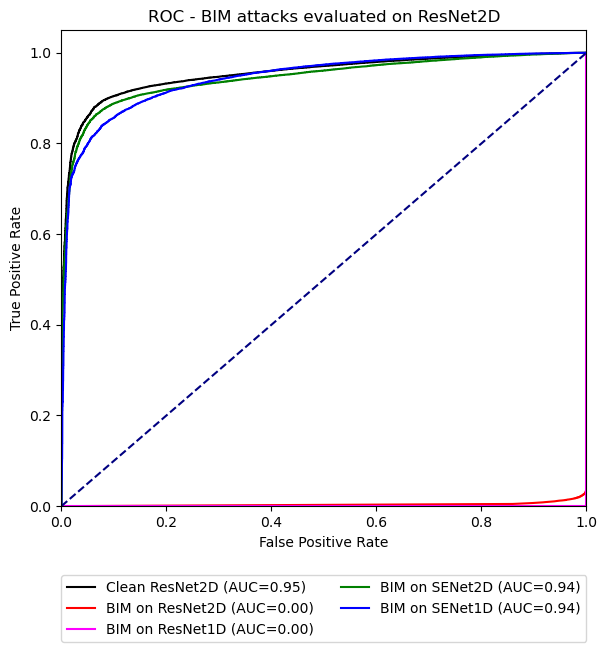

In [63]:
# plot ResNet2D
plt.figure()
plt.gcf().set_size_inches(6, 7)
plt.plot(fpr_Res2D_c, tpr_Res2D_c, color='black', lw=1.5, label='Clean ResNet2D (AUC={:.2f})'.format(roc_auc_Res2D_c))
plt.plot(fpr_Res2D_BIM_Res2D, tpr_Res2D_BIM_Res2D, color='red', lw=1.5, label='BIM on ResNet2D (AUC={:.2f})'.format(roc_auc_Res2D_BIM_Res2D))
plt.plot(fpr_Res2D_BIM_Res1D, tpr_Res2D_BIM_Res1D, color='magenta', lw=1.5, label='BIM on ResNet1D (AUC={:.2f})'.format(roc_auc_Res2D_BIM_Res1D))
plt.plot(fpr_Res2D_BIM_SEN2D, tpr_Res2D_BIM_SEN2D, color='green', lw=1.5, label='BIM on SENet2D (AUC={:.2f})'.format(roc_auc_Res2D_BIM_SEN2D))
plt.plot(fpr_Res2D_BIM_SEN1D, tpr_Res2D_BIM_SEN1D, color='blue', lw=1.5, label='BIM on SENet1D (AUC={:.2f})'.format(roc_auc_Res2D_BIM_SEN1D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - BIM attacks evaluated on ResNet2D')
plt.subplots_adjust(right=1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)  
plt.subplots_adjust(bottom=0.2)
plt.show()

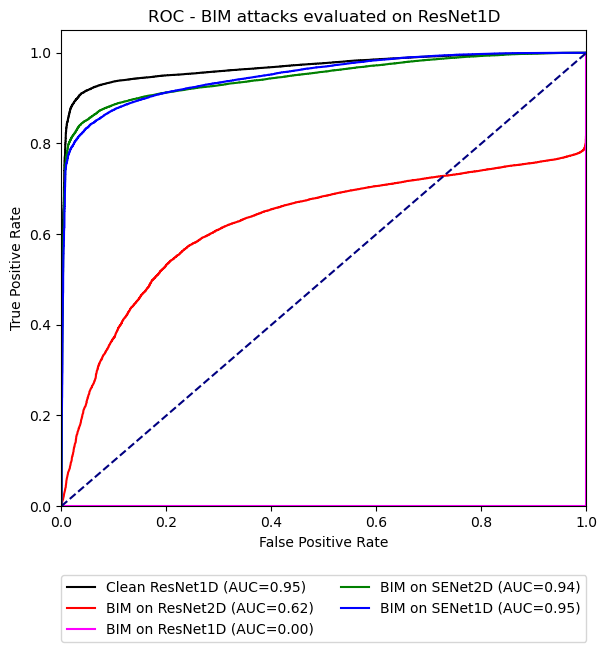

In [76]:
# plot ResNet1D
plt.figure()
plt.gcf().set_size_inches(6, 7)
plt.plot(fpr_Res1D_c, tpr_Res1D_c, color='black', lw=1.5, label='Clean ResNet1D (AUC={:.2f})'.format(roc_auc_Res2D_c))
plt.plot(fpr_Res1D_BIM_Res2D, tpr_Res1D_BIM_Res2D, color='red', lw=1.5, label='BIM on ResNet2D (AUC={:.2f})'.format(roc_auc_Res1D_BIM_Res2D))
plt.plot(fpr_Res1D_BIM_Res1D, tpr_Res1D_BIM_Res1D, color='magenta', lw=1.5, label='BIM on ResNet1D (AUC={:.2f})'.format(roc_auc_Res2D_BIM_Res1D))
plt.plot(fpr_Res1D_BIM_SEN2D, tpr_Res1D_BIM_SEN2D, color='green', lw=1.5, label='BIM on SENet2D (AUC={:.2f})'.format(roc_auc_Res2D_BIM_SEN2D))
plt.plot(fpr_Res1D_BIM_SEN1D, tpr_Res1D_BIM_SEN1D, color='blue', lw=1.5, label='BIM on SENet1D (AUC={:.2f})'.format(roc_auc_Res1D_BIM_SEN1D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - BIM attacks evaluated on ResNet1D')
plt.subplots_adjust(right=1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)  
plt.subplots_adjust(bottom=0.2)
plt.show()

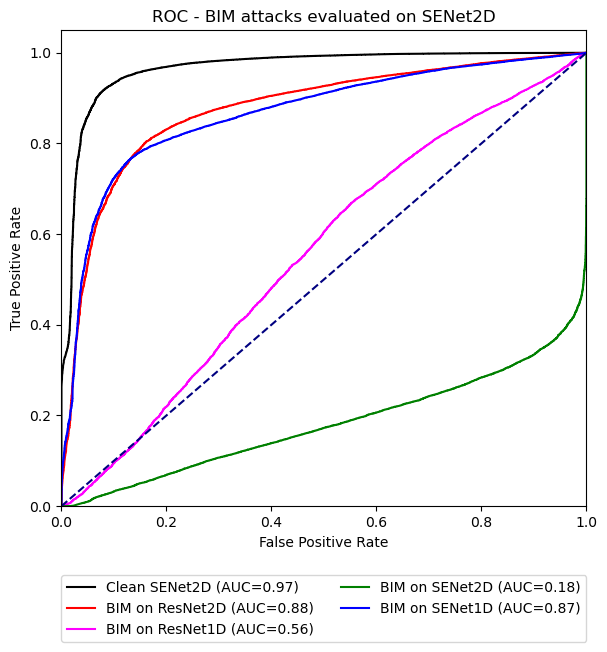

In [64]:
# plot SENet2D
plt.figure()
plt.gcf().set_size_inches(6, 7)
plt.plot(fpr_SEN2D_c, tpr_SEN2D_c, color='black', lw=1.5, label='Clean SENet2D (AUC={:.2f})'.format(roc_auc_SEN2D_c))
plt.plot(fpr_SEN2D_BIM_Res2D, tpr_SEN2D_BIM_Res2D, color='red', lw=1.5, label='BIM on ResNet2D (AUC={:.2f})'.format(roc_auc_SEN2D_BIM_Res2D))
plt.plot(fpr_SEN2D_BIM_Res1D, tpr_SEN2D_BIM_Res1D, color='magenta', lw=1.5, label='BIM on ResNet1D (AUC={:.2f})'.format(roc_auc_SEN2D_BIM_Res1D))
plt.plot(fpr_SEN2D_BIM_SEN2D, tpr_SEN2D_BIM_SEN2D, color='green', lw=1.5, label='BIM on SENet2D (AUC={:.2f})'.format(roc_auc_SEN2D_BIM_SEN2D))
plt.plot(fpr_SEN2D_BIM_SEN1D, tpr_SEN2D_BIM_SEN1D, color='blue', lw=1.5, label='BIM on SENet1D (AUC={:.2f})'.format(roc_auc_SEN2D_BIM_SEN1D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - BIM attacks evaluated on SENet2D')
plt.subplots_adjust(right=1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)  
plt.subplots_adjust(bottom=0.2)
plt.show()

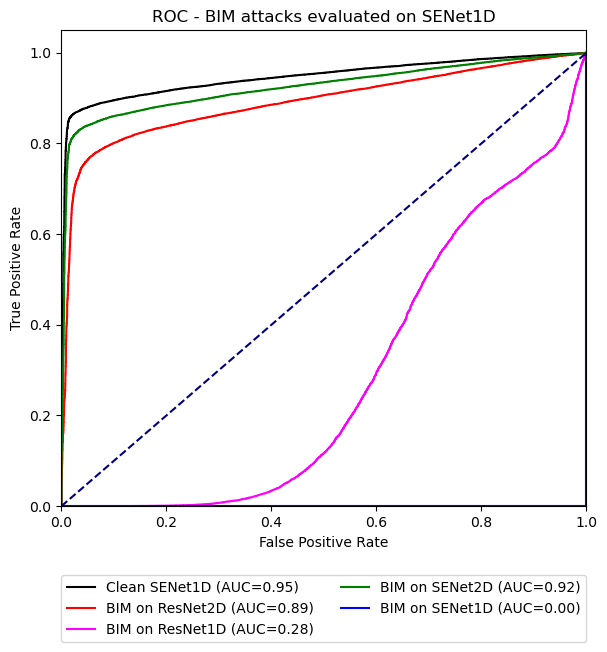

In [73]:
# plot SENet1D
plt.figure()
plt.gcf().set_size_inches(6, 7)
plt.plot(fpr_SEN1D_c, tpr_SEN1D_c, color='black', lw=1.5, label='Clean SENet1D (AUC={:.2f})'.format(roc_auc_SEN1D_c))
plt.plot(fpr_SEN1D_BIM_Res2D, tpr_SEN1D_BIM_Res2D, color='red', lw=1.5, label='BIM on ResNet2D (AUC={:.2f})'.format(roc_auc_SEN1D_BIM_Res2D))
plt.plot(fpr_SEN1D_BIM_Res1D, tpr_SEN1D_BIM_Res1D, color='magenta', lw=1.5, label='BIM on ResNet1D (AUC={:.2f})'.format(roc_auc_SEN1D_BIM_Res1D))
plt.plot(fpr_SEN1D_BIM_SEN2D, tpr_SEN1D_BIM_SEN2D, color='green', lw=1.5, label='BIM on SENet2D (AUC={:.2f})'.format(roc_auc_SEN1D_BIM_SEN2D))
plt.plot(fpr_SEN1D_BIM_SEN1D, tpr_SEN1D_BIM_SEN1D, color='blue', lw=1.5, label='BIM on SENet1D (AUC={:.2f})'.format(roc_auc_SEN1D_BIM_SEN1D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - BIM attacks evaluated on SENet1D')
plt.subplots_adjust(right=1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)  
plt.subplots_adjust(bottom=0.2)
plt.show()

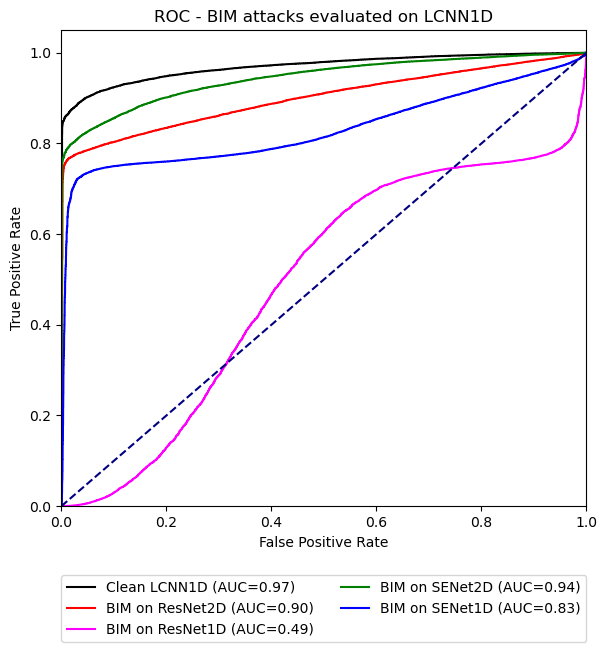

In [80]:
# plot LCNN1D
plt.figure()
plt.gcf().set_size_inches(6, 7)
plt.plot(fpr_LCNN1D_c, tpr_LCNN1D_c, color='black', lw=1.5, label='Clean LCNN1D (AUC={:.2f})'.format(roc_auc_LCNN1D_c))
plt.plot(fpr_LCNN1D_BIM_Res2D, tpr_LCNN1D_BIM_Res2D, color='red', lw=1.5, label='BIM on ResNet2D (AUC={:.2f})'.format(roc_auc_LCNN1D_BIM_Res2D))
plt.plot(fpr_LCNN1D_BIM_Res1D, tpr_LCNN1D_BIM_Res1D, color='magenta', lw=1.5, label='BIM on ResNet1D (AUC={:.2f})'.format(roc_auc_LCNN1D_BIM_Res1D))
plt.plot(fpr_LCNN1D_BIM_SEN2D, tpr_LCNN1D_BIM_SEN2D, color='green', lw=1.5, label='BIM on SENet2D (AUC={:.2f})'.format(roc_auc_LCNN1D_BIM_SEN2D))
plt.plot(fpr_LCNN1D_BIM_SEN1D, tpr_LCNN1D_BIM_SEN1D, color='blue', lw=1.5, label='BIM on SENet1D (AUC={:.2f})'.format(roc_auc_LCNN1D_BIM_SEN1D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - BIM attacks evaluated on LCNN1D')
plt.subplots_adjust(right=1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)  
plt.subplots_adjust(bottom=0.2)
plt.show()

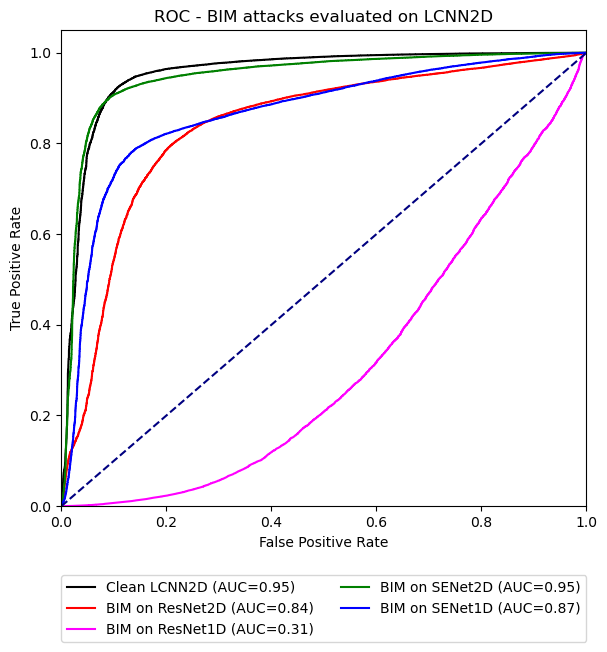

In [81]:
# plot LCNN2D
plt.figure()
plt.gcf().set_size_inches(6, 7)
plt.plot(fpr_LCNN2D_c, tpr_LCNN2D_c, color='black', lw=1.5, label='Clean LCNN2D (AUC={:.2f})'.format(roc_auc_LCNN2D_c))
plt.plot(fpr_LCNN2D_BIM_Res2D, tpr_LCNN2D_BIM_Res2D, color='red', lw=1.5, label='BIM on ResNet2D (AUC={:.2f})'.format(roc_auc_LCNN2D_BIM_Res2D))
plt.plot(fpr_LCNN2D_BIM_Res1D, tpr_LCNN2D_BIM_Res1D, color='magenta', lw=1.5, label='BIM on ResNet1D (AUC={:.2f})'.format(roc_auc_LCNN2D_BIM_Res1D))
plt.plot(fpr_LCNN2D_BIM_SEN2D, tpr_LCNN2D_BIM_SEN2D, color='green', lw=1.5, label='BIM on SENet2D (AUC={:.2f})'.format(roc_auc_LCNN2D_BIM_SEN2D))
plt.plot(fpr_LCNN2D_BIM_SEN1D, tpr_LCNN2D_BIM_SEN1D, color='blue', lw=1.5, label='BIM on SENet1D (AUC={:.2f})'.format(roc_auc_LCNN2D_BIM_SEN1D))
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - BIM attacks evaluated on LCNN2D')
plt.subplots_adjust(right=1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)  
plt.subplots_adjust(bottom=0.2)
plt.show()

***
## Ensemble ResNet1D - RawNet

In [30]:
_,_,_, fpr_Rawnet2_Ens1D_ResRaw, tpr_Rawnet2_Ens1D_ResRaw, roc_auc_Rawnet2_Ens1D_ResRaw, _, eer_Rawnet2_Ens1D_ResRaw = ROC(attack='Ens1D', attack_model='ResRaw', epsilon=None, eps1=0.008, eps2=0.01, q_1=20, q_2=50,  eval_model='Rawnet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResRaw with q1=20, q2=50, eps1=0.008, eps2=0.01 evaluated on Rawnet
AUC clean: 0.991, EER clean: 4.908
--> AUC perturbed: 0.015, EER perturbed: 94.317 <-- 
------------------------


In [31]:
_,_,_, fpr_ResNet1D_Ens1D_ResRaw, tpr_ResNet1D_Ens1D_ResRaw, roc_auc_ResNet1D_Ens1D_ResRaw, _, eer_ResNet1D_Ens1D_ResRaw = ROC(attack='Ens1D', attack_model='ResRaw', epsilon=None, eps1=0.008, eps2=0.01, q_1=20, q_2=50,  eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResRaw with q1=20, q2=50, eps1=0.008, eps2=0.01 evaluated on ResNet1D
AUC clean: 0.968, EER clean: 7.179
--> AUC perturbed: 0.013, EER perturbed: 99.524 <-- 
------------------------


In [32]:
_,_,_, fpr_SENet1D_Ens1D_ResRaw, tpr_SENet1D_Ens1D_ResRaw, roc_auc_SENet1D_Ens1D_ResRaw, _, eer_SENet1D_Ens1D_ResRaw = ROC(attack='Ens1D', attack_model='ResRaw', epsilon=None, eps1=0.008, eps2=0.01, q_1=20, q_2=50,  eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResRaw with q1=20, q2=50, eps1=0.008, eps2=0.01 evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.374
--> AUC perturbed: 0.861, EER perturbed: 18.817 <-- 
------------------------


In [33]:
_,_,_, fpr_LCNN1D_Ens1D_ResRaw, tpr_LCNN1D_Ens1D_ResRaw, roc_auc_LCNN1D_Ens1D_ResRaw, _, eer_LCNN1D_Ens1D_ResRaw = ROC(attack='Ens1D', attack_model='ResRaw', epsilon=None, eps1=0.008, eps2=0.01, q_1=20, q_2=50,  eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResRaw with q1=20, q2=50, eps1=0.008, eps2=0.01 evaluated on LCNN1D
AUC clean: 0.969, EER clean: 8.226
--> AUC perturbed: 0.588, EER perturbed: 34.303 <-- 
------------------------


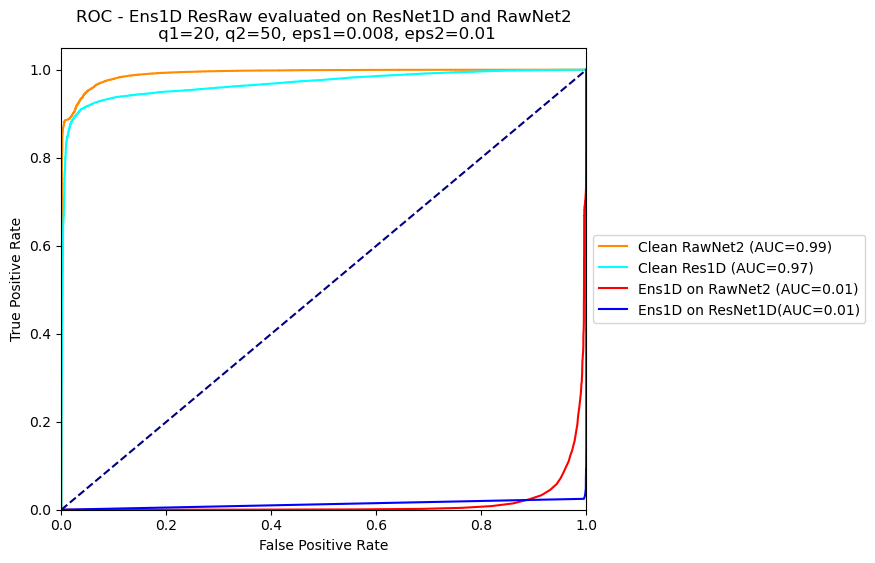

In [34]:
# plot Ensemble
plt.figure()
plt.gcf().set_size_inches(6, 6)
plt.plot(fpr_RawNet2_c, tpr_RawNet2_c, color='darkorange', lw=1.5, label='Clean RawNet2 (AUC={:.2f})'.format(roc_auc_RawNet2_c))
plt.plot(fpr_Res1D_c, tpr_Res1D_c, color='cyan', lw=1.5, label='Clean Res1D (AUC={:.2f})'.format(roc_auc_Res1D_c))
plt.plot(fpr_Rawnet2_Ens1D_ResRaw, tpr_Rawnet2_Ens1D_ResRaw, color='red', lw=1.5, label='Ens1D on RawNet2 (AUC={:.2f})'.format(roc_auc_Rawnet2_Ens1D_ResRaw))
plt.plot(fpr_ResNet1D_Ens1D_ResRaw, tpr_ResNet1D_Ens1D_ResRaw, color='blue', lw=1.5, label='Ens1D on ResNet1D(AUC={:.2f})'.format(roc_auc_ResNet1D_Ens1D_ResRaw) )
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - Ens1D ResRaw evaluated on ResNet1D and RawNet2\n q1=20, q2=50, eps1=0.008, eps2=0.01')
plt.subplots_adjust(right=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

***
## Ensemble ResNet1D - SENet1D

In [35]:
_,_,_, fpr_ResNet1D_Ens1D_ResSEN, tpr_ResNet1D_Ens1D_ResSEN, roc_auc_ResNet1D_Ens1D_ResSEN, _, eer_ResNet1D_Ens1D_ResSEN = ROC(attack='Ens1D', attack_model='ResSEN', epsilon=None, eps1=0.009, eps2=0.002, q_1=30, q_2=50,  eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSEN with q1=30, q2=50, eps1=0.009, eps2=0.002 evaluated on ResNet1D
AUC clean: 0.968, EER clean: 7.179
--> AUC perturbed: 0.042, EER perturbed: 99.986 <-- 
------------------------


In [36]:
_,_,_, fpr_SENet1D_Ens1D_ResSEN, tpr_SENet1D_Ens1D_ResSEN, roc_auc_SENet1D_Ens1D_ResSEN, _, eer_SENet1D_Ens1D_ResSEN = ROC(attack='Ens1D', attack_model='ResSEN', epsilon=None, eps1=0.009, eps2=0.002, q_1=30, q_2=50,  eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSEN with q1=30, q2=50, eps1=0.009, eps2=0.002 evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.374
--> AUC perturbed: 0.300, EER perturbed: 59.157 <-- 
------------------------


In [37]:
_,_,_, fpr_RawNet_Ens1D_ResSEN, tpr_RawNet_Ens1D_ResSEN, roc_auc_RawNet_Ens1D_ResSEN, _, eer_RawNet_Ens1D_ResSEN = ROC(attack='Ens1D', attack_model='ResSEN', epsilon=None, eps1=0.009, eps2=0.002, q_1=30, q_2=50,  eval_model='Rawnet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSEN with q1=30, q2=50, eps1=0.009, eps2=0.002 evaluated on Rawnet
AUC clean: 0.991, EER clean: 4.908
--> AUC perturbed: 0.991, EER perturbed: 5.112 <-- 
------------------------


In [38]:
_,_,_, fpr_LCNN1D_Ens1D_ResSEN, tpr_LCNN1D_Ens1D_ResSEN, roc_auc_LCNN1D_Ens1D_ResSEN, _, eer_LCNN1D_Ens1D_ResSEN = ROC(attack='Ens1D', attack_model='ResSEN', epsilon=None, eps1=0.009, eps2=0.002, q_1=30, q_2=50,  eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSEN with q1=30, q2=50, eps1=0.009, eps2=0.002 evaluated on LCNN1D
AUC clean: 0.969, EER clean: 8.226
--> AUC perturbed: 0.641, EER perturbed: 29.028 <-- 
------------------------


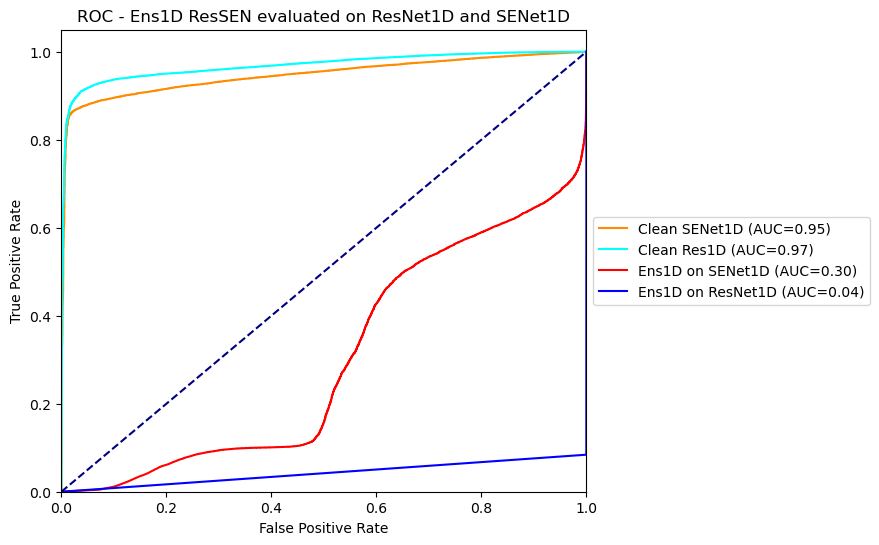

In [39]:
# plot Ensemble
plt.figure()
plt.gcf().set_size_inches(6, 6)
plt.plot(fpr_SEN1D_c, tpr_SEN1D_c, color='darkorange', lw=1.5, label='Clean SENet1D (AUC={:.2f})'.format(roc_auc_SEN1D_c))
plt.plot(fpr_Res1D_c, tpr_Res1D_c, color='cyan', lw=1.5, label='Clean Res1D (AUC={:.2f})'.format(roc_auc_Res1D_c))
plt.plot(fpr_SENet1D_Ens1D_ResSEN, tpr_SENet1D_Ens1D_ResSEN, color='red', lw=1.5, label='Ens1D on SENet1D (AUC={:.2f})'.format(roc_auc_SENet1D_Ens1D_ResSEN))
plt.plot(fpr_ResNet1D_Ens1D_ResSEN, tpr_ResNet1D_Ens1D_ResSEN, color='blue', lw=1.5, label='Ens1D on ResNet1D (AUC={:.2f})'.format(roc_auc_ResNet1D_Ens1D_ResSEN) )
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - Ens1D ResSEN evaluated on ResNet1D and SENet1D')
plt.subplots_adjust(right=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [40]:
_,_ = ROC_clean_only(eval_model='ResNet2D', model_version='v1', dataset='whole', type_of_spec='pow', feature='spec')

spec -- AUC = 0.307, EER = 63.766


In [41]:
_,_ = ROC_clean_only(eval_model='ResNet2D', model_version='v1', dataset='whole', type_of_spec='pow', feature='audio')

audio -- AUC = 0.318, EER = 62.634


***
## Ensemble RawNet2-SENEt

In [42]:
_,_,_, fpr_SENet1D_Ens1D_RawSEN, tpr_SENet1D_Ens1D_RawSEN, roc_auc_SENet1D_Ens1D_RawSEN, _, eer_SENet1D_Ens1D_RawSEN = ROC(attack='Ens1D', attack_model='RawSEN', epsilon=None, eps1=0.005, eps2=0.002, q_1=20, q_2=60,  eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on RawSEN with q1=20, q2=60, eps1=0.005, eps2=0.002 evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.374
--> AUC perturbed: 0.511, EER perturbed: 42.203 <-- 
------------------------


In [43]:
_,_,_, fpr_Rawnet2_Ens1D_RawSEN, tpr_Rawnet2_Ens1D_RawSEN, roc_auc_Rawnet2_Ens1D_RawSEN, _, eer_Rawnet2_Ens1D_RawSEN = ROC(attack='Ens1D', attack_model='RawSEN', epsilon=None, eps1=0.005, eps2=0.002, q_1=20, q_2=60,  eval_model='Rawnet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on RawSEN with q1=20, q2=60, eps1=0.005, eps2=0.002 evaluated on Rawnet
AUC clean: 0.991, EER clean: 4.908
--> AUC perturbed: 0.010, EER perturbed: 93.977 <-- 
------------------------


In [44]:
_,_,_, fpr_ResNet1D_Ens1D_RawSEN, tpr_ResNet1D_Ens1D_RawSEN, roc_auc_ResNet1D_Ens1D_RawSEN, _, eer_ResNet1D_Ens1D_RawSEN = ROC(attack='Ens1D', attack_model='RawSEN', epsilon=None, eps1=0.005, eps2=0.002, q_1=20, q_2=60,  eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on RawSEN with q1=20, q2=60, eps1=0.005, eps2=0.002 evaluated on ResNet1D
AUC clean: 0.968, EER clean: 7.179
--> AUC perturbed: 0.851, EER perturbed: 17.444 <-- 
------------------------


In [45]:
_,_,_, fpr_LCNN1D_Ens1D_RawSEN, tpr_LCNN1D_Ens1D_RawSEN, roc_auc_LCNN1D_Ens1D_RawSEN, _, eer_LCNN1D_Ens1D_RawSEN = ROC(attack='Ens1D', attack_model='RawSEN', epsilon=None, eps1=0.005, eps2=0.002, q_1=20, q_2=60,  eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on RawSEN with q1=20, q2=60, eps1=0.005, eps2=0.002 evaluated on LCNN1D
AUC clean: 0.969, EER clean: 8.226
--> AUC perturbed: 0.828, EER perturbed: 20.938 <-- 
------------------------


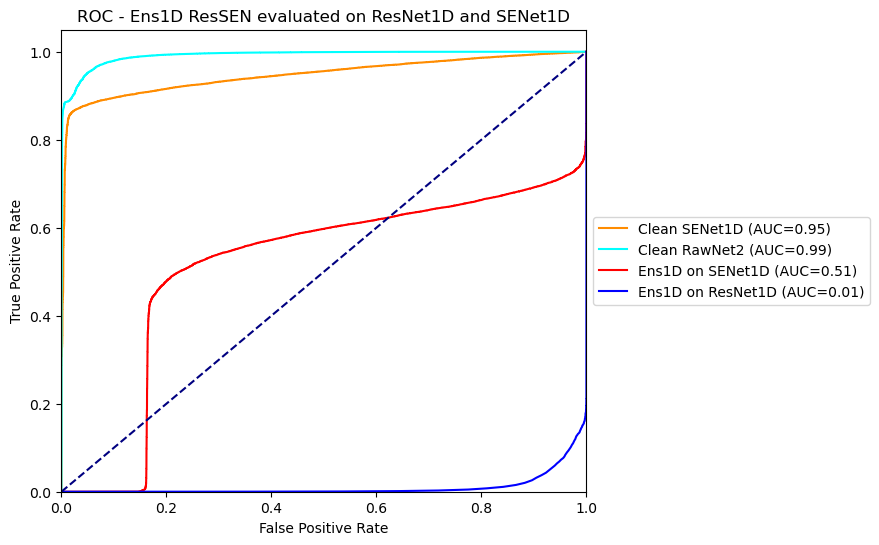

In [46]:
# plot Ensemble
plt.figure()
plt.gcf().set_size_inches(6, 6)
plt.plot(fpr_SEN1D_c, tpr_SEN1D_c, color='darkorange', lw=1.5, label='Clean SENet1D (AUC={:.2f})'.format(roc_auc_SEN1D_c))
plt.plot(fpr_RawNet2_c, tpr_RawNet2_c, color='cyan', lw=1.5, label='Clean RawNet2 (AUC={:.2f})'.format(roc_auc_RawNet2_c))
plt.plot(fpr_SENet1D_Ens1D_RawSEN, tpr_SENet1D_Ens1D_RawSEN, color='red', lw=1.5, label='Ens1D on SENet1D (AUC={:.2f})'.format(roc_auc_SENet1D_Ens1D_RawSEN))
plt.plot(fpr_Rawnet2_Ens1D_RawSEN, tpr_Rawnet2_Ens1D_RawSEN, color='blue', lw=1.5, label='Ens1D on ResNet1D (AUC={:.2f})'.format(roc_auc_Rawnet2_Ens1D_RawSEN) )
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - Ens1D ResSEN evaluated on ResNet1D and SENet1D')
plt.subplots_adjust(right=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

***
## Ensemble 3 = Res, Raw, SEN

In [47]:
_,_,_, fpr_ResNet1D_Ens1D_ResSENRaw, tpr_ResNet1D_Ens1D_ResSENRaw, roc_auc_ResNet1D_Ens1D_ResSENRaw, _, eer_ResNet1D_Ens1D_ResSENRaw = ROC(attack='Ens1D', attack_model='ResSENRaw', epsilon=None, eps1=0.03, eps2=0.008, eps3=0.02, q_1=50, q_2=80, q_3=60, trip=1,  eval_model='ResNet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSENRaw with q1=50, q2=80, q3=60, eps1=0.03, eps2=0.008, eps3=0.02  evaluated on ResNet1D
AUC clean: 0.969, EER clean: 6.863
--> AUC perturbed: 0.534, EER perturbed: 48.319 <-- 
------------------------


In [48]:
_,_,_, fpr_LCNN1D_Ens1D_ResSENRaw, tpr_LCNN1D_Ens1D_ResSENRaw, roc_auc_LCNN1D_Ens1D_ResSENRaw, _, eer_LCNN1D_Ens1D_ResSENRaw = ROC(attack='Ens1D', attack_model='ResSENRaw', epsilon=None, eps1=0.03, eps2=0.008, eps3=0.02, q_1=50, q_2=80, q_3=60, trip=1,  eval_model='LCNN1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSENRaw with q1=50, q2=80, q3=60, eps1=0.03, eps2=0.008, eps3=0.02  evaluated on LCNN1D
AUC clean: 0.971, EER clean: 7.983
--> AUC perturbed: 0.764, EER perturbed: 25.210 <-- 
------------------------


In [49]:
_,_,_, fpr_SENet1D_Ens1D_ResSENRaw, tpr_SENet1D_Ens1D_ResSENRaw, roc_auc_SENet1D_Ens1D_ResSENRaw, _, eer_SENet1D_Ens1D_ResSENRaw = ROC(attack='Ens1D', attack_model='ResSENRaw', epsilon=None, eps1=0.03, eps2=0.008, eps3=0.02, q_1=50, q_2=80, q_3=60, trip=1,  eval_model='SENet1D', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSENRaw with q1=50, q2=80, q3=60, eps1=0.03, eps2=0.008, eps3=0.02  evaluated on SENet1D
AUC clean: 0.947, EER clean: 10.224
--> AUC perturbed: 0.285, EER perturbed: 55.182 <-- 
------------------------


In [50]:
_,_,_, fpr_Rawnet2_Ens1D_ResSENRaw, tpr_Rawnet2_Ens1D_ResSENRaw, roc_auc_Rawnet2_Ens1D_ResSENRaw, _, eer_Rawnet2_Ens1D_ResSENRaw = ROC(attack='Ens1D', attack_model='ResSENRaw', epsilon=None, eps1=0.03, eps2=0.008, eps3=0.02, q_1=50, q_2=80, q_3=60, trip=1,  eval_model='Rawnet', model_version='v0', dataset='whole', type_of_spec='pow', feature='audio')

audio - Ens1D on ResSENRaw with q1=50, q2=80, q3=60, eps1=0.03, eps2=0.008, eps3=0.02  evaluated on Rawnet
AUC clean: 0.991, EER clean: 4.622
--> AUC perturbed: 0.263, EER perturbed: 61.345 <-- 
------------------------


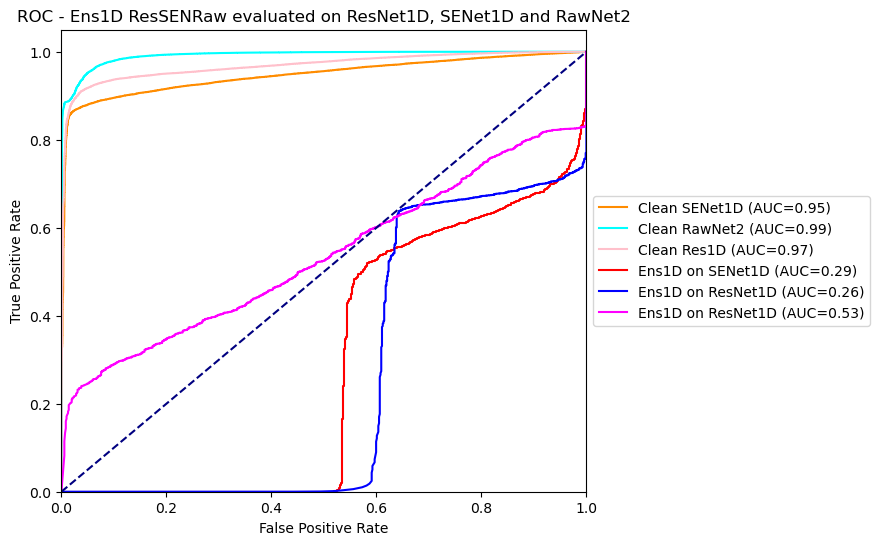

In [51]:
# plot Ensemble
plt.figure()
plt.gcf().set_size_inches(6, 6)
plt.plot(fpr_SEN1D_c, tpr_SEN1D_c, color='darkorange', lw=1.5, label='Clean SENet1D (AUC={:.2f})'.format(roc_auc_SEN1D_c))
plt.plot(fpr_RawNet2_c, tpr_RawNet2_c, color='cyan', lw=1.5, label='Clean RawNet2 (AUC={:.2f})'.format(roc_auc_RawNet2_c))
plt.plot(fpr_Res1D_c, tpr_Res1D_c, color='pink', lw=1.5, label='Clean Res1D (AUC={:.2f})'.format(roc_auc_Res1D_c))
plt.plot(fpr_SENet1D_Ens1D_ResSENRaw, tpr_SENet1D_Ens1D_ResSENRaw, color='red', lw=1.5, label='Ens1D on SENet1D (AUC={:.2f})'.format(roc_auc_SENet1D_Ens1D_ResSENRaw))
plt.plot(fpr_Rawnet2_Ens1D_ResSENRaw, tpr_Rawnet2_Ens1D_ResSENRaw, color='blue', lw=1.5, label='Ens1D on ResNet1D (AUC={:.2f})'.format(roc_auc_Rawnet2_Ens1D_ResSENRaw) )
plt.plot(fpr_ResNet1D_Ens1D_ResSENRaw, tpr_ResNet1D_Ens1D_ResSENRaw, color='magenta', lw=1.5, label='Ens1D on ResNet1D (AUC={:.2f})'.format(roc_auc_ResNet1D_Ens1D_ResSENRaw) )
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
# Set axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC - Ens1D ResSENRaw evaluated on ResNet1D, SENet1D and RawNet2')
plt.subplots_adjust(right=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

***
## Logmag spectrograms

In [52]:
roc_auc_c_Res2D_logmag, eer_c_Res2D_logmag = ROC_clean_only(eval_model='ResNet2D', model_version='v0', dataset='whole', type_of_spec='logmag', feature='audio')

audio -- AUC = 0.954, EER = 10.048
